# Домашнее задание № 24
## Козел А.Г. 1.02.23 

Для произвольно выбранного датасета провести обработку данных и построить предсказательную модель с использованием функционала pySpark.

In [25]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, isnull, desc_nulls_first, desc, \
    from_unixtime, col, dayofweek, dayofyear, hour, to_date, month
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [3]:
# Создаем спарк-сессию
spark = SparkSession.builder.getOrCreate()

In [4]:
# Загружаем датасет
spark = SparkSession(spark)
wine = spark.read.csv("winequality-red.csv",
                      inferSchema="true", 
                      header="true", 
                      sep =';')

wine.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

### Подготовка данных

In [5]:
# Выполняем анализ датасета и представленными колонками. Как видно, в датасете нет категориальных переменных
wine.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [6]:
# Определим наличие NAN значений в датасете, пустых значений нет
wine.select([count(when(isnan(c), c)).alias(c)\
             for c in wine.columns]).head().asDict() 

{'fixed acidity': 0,
 'volatile acidity': 0,
 'citric acid': 0,
 'residual sugar': 0,
 'chlorides': 0,
 'free sulfur dioxide': 0,
 'total sulfur dioxide': 0,
 'density': 0,
 'pH': 0,
 'sulphates': 0,
 'alcohol': 0,
 'quality': 0}

In [7]:
# Выведем общее количество записей в датасете
wine.count()

1599

In [10]:
# Количество дубликатов в сете
wine.count()-wine.dropDuplicates().count() 

240

In [11]:
# Воспользуемся функцией distinct для удаления дубликатов и повторно выведем количество записей в датасете
wine = wine.distinct()
wine.count()

1359

### Анализ данных

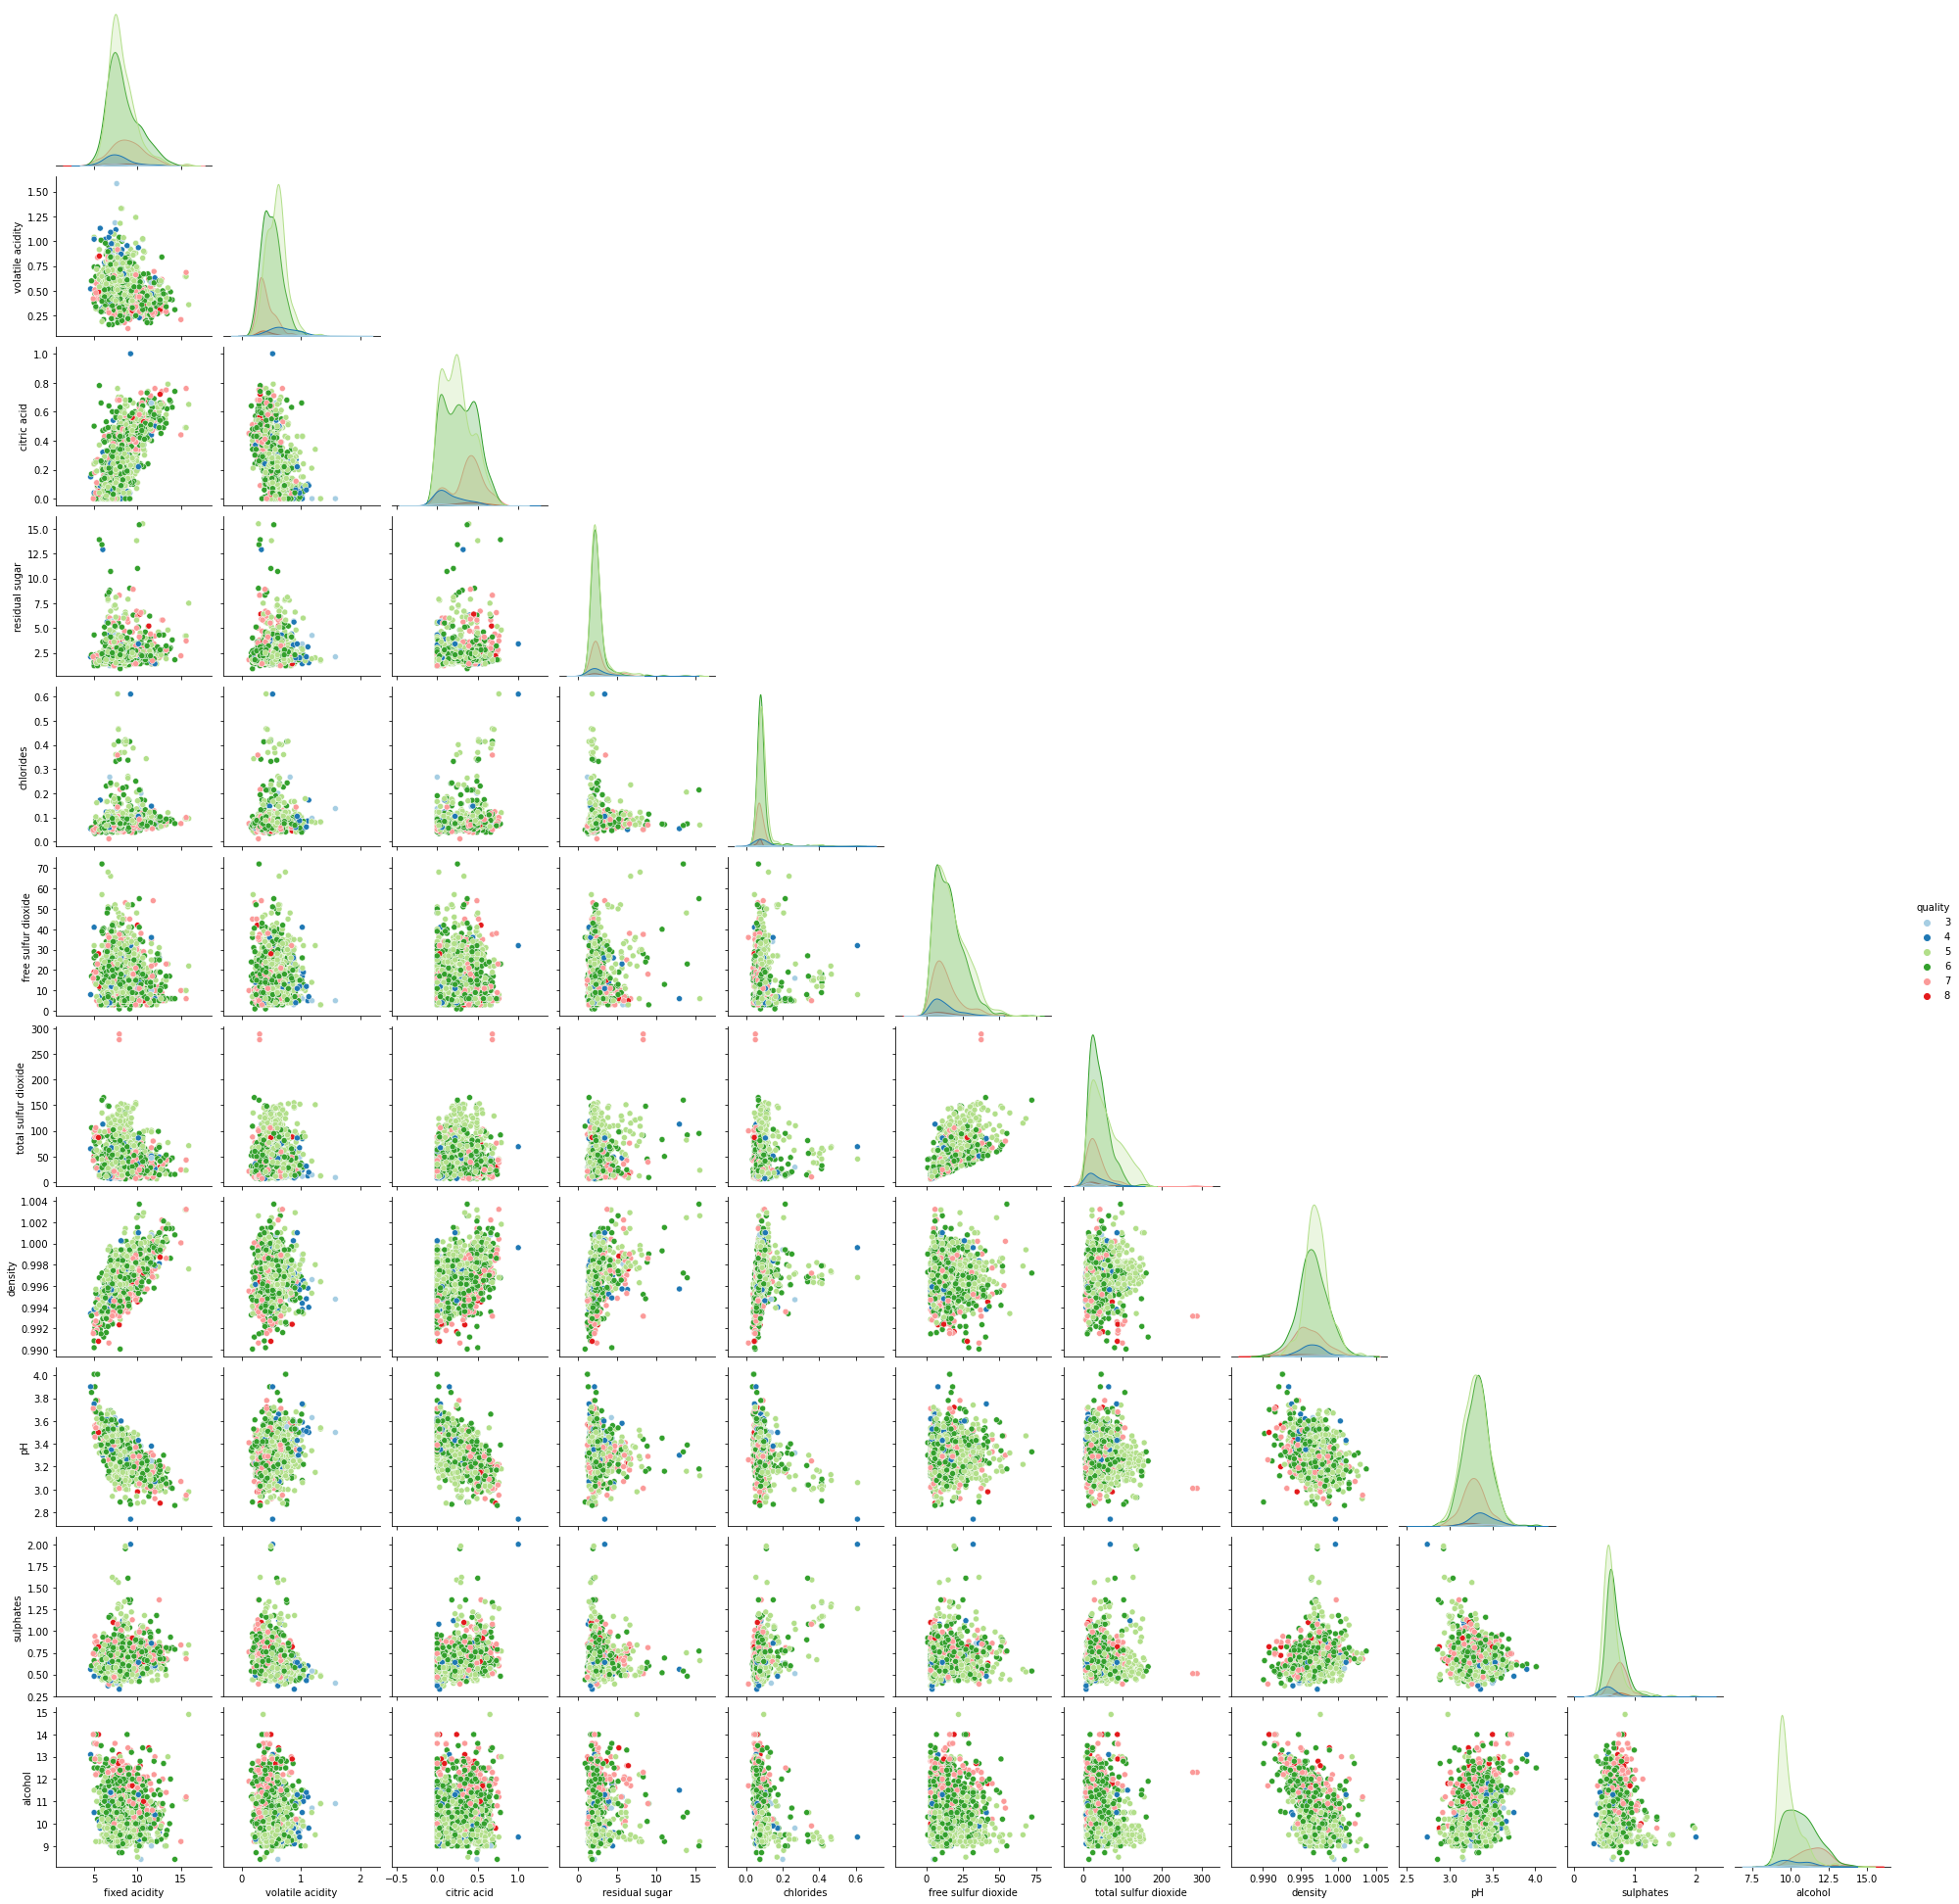

In [14]:
sns.pairplot(wine.toPandas(),
            corner=True,
            hue='quality',
            palette='Paired')

<AxesSubplot:>

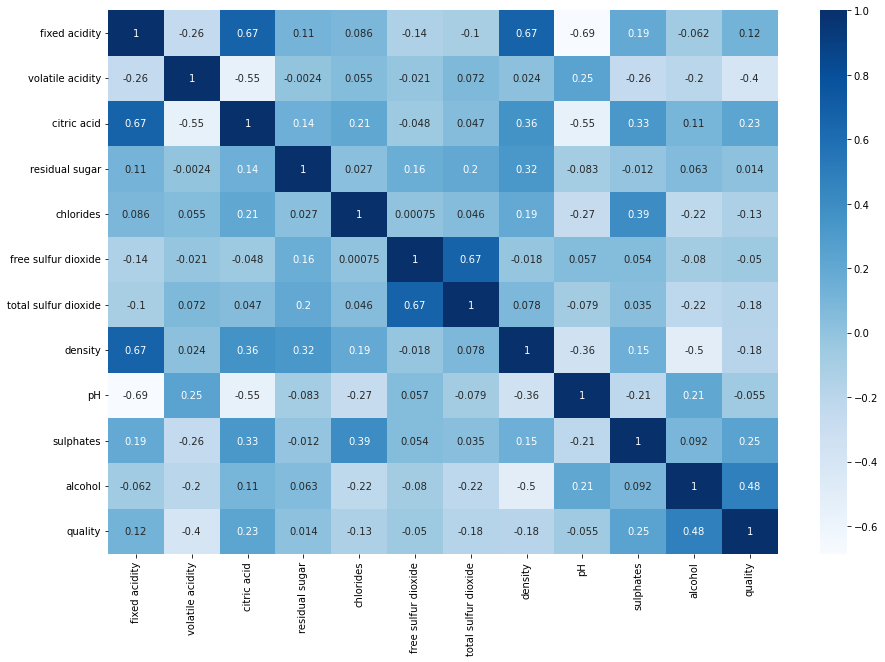

In [15]:
assembler = VectorAssembler(inputCols=wine.columns, outputCol="corr_features")
df = assembler.transform(wine).select("corr_features")

matrix = Correlation.corr(df, "corr_features")
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

plt.figure(figsize=(15,10))  
sns.heatmap(cor_np, 
            xticklabels=wine.columns,
            yticklabels=wine.columns,  
            cmap="Blues", 
            annot=True)

Целевая переменная имеет прямую зависимость от параметра alcohol - 0.48.



## Построение модели
- Поскольку Spark может обучить модель на преобразованных данных, где предсказываемая колонка является вектором и колонки с признаками тоже — вектор, сначала преобразуем нашу целевую колонку(quality) в вектор.
- Поскольку категориальных признаков в данном датасете нету, преобразуем оставшиеся колонки с признаками в один вектор, что можно достичь с помощью VectorAssembler(), который берёт на вход название численных (для этого мы и преобразовали строки в числа в предыдущем шаге) колонок (assemblerInputs) и преобразовываем все колонки в один вектор с именем «features»

In [16]:
#quality - это зависимая и предсказываемая переменная - метка
stages = []
label_stringIdx = StringIndexer(inputCol = 'quality', outputCol = 'label', handleInvalid = 'keep')
stages += [label_stringIdx]

In [17]:
numericCols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
               'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH','sulphates',
               'alcohol']
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Subscribed")
stages += [assembler]

In [18]:
# делим данные на обучающую и тестовую выборки (30% тестовая)
(trainingData, testData) = wine.randomSplit([0.7, 0.3])

# тренируем модель (градиентного регрессионого дерева бустинга)
gbt = GBTRegressor(labelCol="label", featuresCol="Subscribed", maxIter=10)
stages += [gbt]

# задаем план stages для обучения модели 
pipeline = Pipeline(stages=stages)

In [19]:
# тренируем модель
model = pipeline.fit(trainingData)

# делаем предсказания на тестовой выборке
predictions = model.transform(testData)

In [20]:
predictions.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+----------------+-------+-----+--------------------+-------------------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|         alcohol|quality|label|          Subscribed|         prediction|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+----------------+-------+-----+--------------------+-------------------+
|          4.6|            0.52|       0.15|           2.1|    0.054|                8.0|                65.0| 0.9934| 3.9|     0.56|            13.1|      4|  3.0|[4.6,0.52,0.15,2....| 1.1781791336438079|
|          4.9|            0.42|        0.0|           2.1|    0.048|               16.0|                42.0|0.99154|3.71|     0.74|            14.0|      7|  2.0|[4.9,0.42,0.

In [33]:
from pyspark.ml.classification import RandomForestClassifier

pipelineModel = pipeline.fit(wine)
df = pipelineModel.transform(wine)
selectedCols = ['label', 'Subscribed'] + numericCols
df = df.select(selectedCols)

train, test = df.randomSplit([0.8, 0.2], seed = 70)

rf = RandomForestClassifier(featuresCol = 'Subscribed', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [34]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(metricName="weightedFMeasure")
print('F-1 Score', evaluator.evaluate(predictions))
#Это среднее гармоническое двух других показателей, а именно: точности и полноты. 

F-1 Score 0.5771353007091216
